# Mask R-CNN - Train on Teeth Dataset


This notebook shows how to train Mask R-CNN on your own dataset.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from os.path import join


MASK_DIR = "/opt/Mask_RCNN/"

import sys
sys.path.insert(0, MASK_DIR)

from mrcnn.config import Config
import mrcnn.utils
import mrcnn.model as modellib
import mrcnn.visualize
from mrcnn.model import log
import skimage
from skimage.filters import threshold_mean
from skimage.color import rgb2gray, gray2rgb

%matplotlib inline 

# Root directory of the project
ROOT_DIR = MASK_DIR#os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = "/workspace/teeth_net/logs_27_05_2"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8,16,32,64,128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

class TeethConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "teeth"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    
    STEPS_PER_EPOCH = 10

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # BG has 80 classes
    
config = TeethConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

## Notebook Preferences

In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class TeethDataset(mrcnn.utils.Dataset):
    
    def __init__(self, dataset_path):
        
        self.dataset_path = dataset_path
        super(TeethDataset,self).__init__()
    
    def load_teeth(self):

        # Add classes
        self.add_class("teeth", 1, "tooth")
        
        img_dataset = join(self.dataset_path, "train2018")
        count = 0
        for root, dirs, files in os.walk(img_dataset):
            id_imgs = [file.strip("img").strip(".jpg") for file in files]
            id_paths = [join(root,file) for file in files]
            masks_paths = [join(root,file).replace("train2018", "masks").replace("jpg", "bmp") for file in files]
            for image_id, image_path, mask_path in zip(id_imgs, id_paths, masks_paths):
                if os.path.exists(mask_path):
                    self.add_image("teeth",
                                   image_id=count,
                                   path=image_path,
                                   image_path_id=image_id
                                   )
                    count += 1
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        
        path_mask = info['path']
        path_mask = path_mask.replace("train2018", "masks")
        path_mask = path_mask.replace("jpg", "bmp")
        
        image_mask = skimage.color.rgb2gray(skimage.io.imread(path_mask))
        
        #image = gray2rgb(image)

        ret, thresh = cv2.threshold(image_mask, 0, 255, 0)
        im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        class_ids = np.ones(len(contours), np.int32)
        
        masks = np.zeros((image_mask.shape[0],image_mask.shape[1], len(contours)), dtype=np.bool)
        
        for i in range(len(contours)):
            img_cont = np.zeros((image_mask.shape[0],image_mask.shape[1],3) , dtype=image.dtype)
            
            cv2.drawContours(img_cont, contours, i, (255,255,255), -1)

            bimask = np.zeros(img_cont.shape[0:2], dtype=np.uint8)

            bimask = img_cont[:,:, 0]
            
            thresh = threshold_mean(bimask)
            mask = bimask > thresh
            masks[:, :, i]= mask

        print(masks.shape)
            
        return masks, class_ids   
        
    

In [5]:
    
teeth_dataset_train = TeethDataset("/workspace/teeth_net/TEETH_DATASET/")
teeth_dataset_train.load_teeth()
teeth_dataset_train.prepare()

#teeth_dataset_eval = TeethDataset("./dataset_gil/eval/original_images/")
#teeth_dataset_eval.load_teeth()
#teeth_dataset_eval.prepare()



(1127, 1991, 49)
127


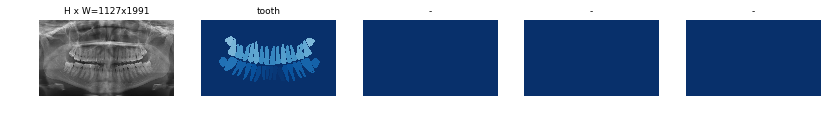

(1127, 1991, 52)
203


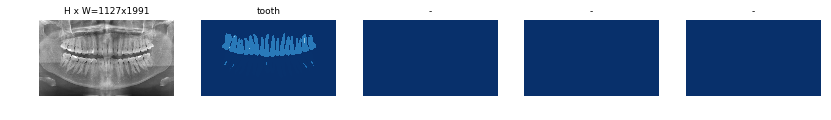

(1127, 1991, 9)
170


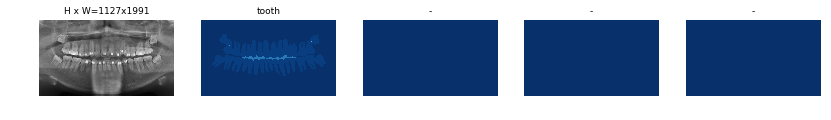

(1127, 1991, 23)
227


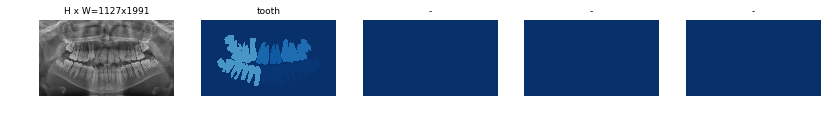

(1127, 1991, 27)
11


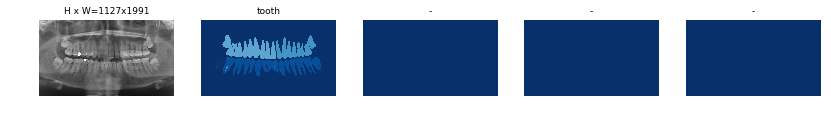

(1127, 1991, 25)
98


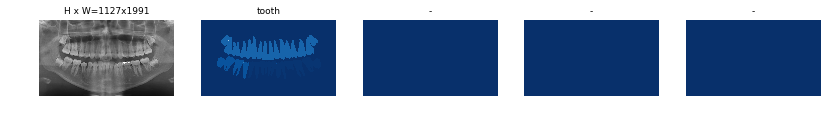

In [11]:
# Load and display random samples
image_ids = np.random.choice(teeth_dataset_train.image_ids, 6)
for image_id in image_ids:
    image = teeth_dataset_train.load_image(image_id)
    mask, class_ids = teeth_dataset_train.load_mask(image_id)
    print(image_id)
    mrcnn.visualize.display_top_masks(image, mask, class_ids, teeth_dataset_train.class_names)

## Ceate Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

NameError: name 'model' is not defined

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(teeth_dataset_train, teeth_dataset_train, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /workspace/teeth_net/logs_27_05/teeth20180527T1943/mask_rcnn_teeth_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_m

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/2


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(teeth_dataset_train, teeth_dataset_eval, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=1000, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /workspace/logs/shapes20180304T0124/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b       

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1000
100/100 [==============================] - 109s 1s/step - loss: 1.5875 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.1503 - mrcnn_class_loss: 0.2968 - mrcnn_bbox_loss: 0.5516 - mrcnn_mask_loss: 0.5649 - val_loss: 0.6911 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.0547 - val_mrcnn_class_loss: 0.0192 - val_mrcnn_bbox_loss: 0.0936 - val_mrcnn_mask_loss: 0.5190
Epoch 2/1000
100/100 [==============================] - 91s 913ms/step - loss: 0.6043 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.5051 - val_loss: 0.5714 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.0297 - val_mrcnn_class_loss: 0.0152 - val_mrcnn_bbox_loss: 0.0463 - val_mrcnn_mask_loss: 0.4786
Epoch 3/1000
100/100 [==============================] - 91s 908ms/step - loss: 0.5539 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.4798 - val_loss: 0.5300 - val_r

Epoch 22/1000
100/100 [==============================] - 91s 910ms/step - loss: 0.3974 - rpn_class_loss: 2.8830e-04 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 1.2356e-04 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.3579 - val_loss: 0.4099 - val_rpn_class_loss: 2.1337e-04 - val_rpn_bbox_loss: 0.0172 - val_mrcnn_class_loss: 1.5462e-04 - val_mrcnn_bbox_loss: 0.0233 - val_mrcnn_mask_loss: 0.3691
Epoch 23/1000
100/100 [==============================] - 91s 907ms/step - loss: 0.3943 - rpn_class_loss: 3.2866e-04 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 1.4086e-04 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.3544 - val_loss: 0.4058 - val_rpn_class_loss: 2.0334e-04 - val_rpn_bbox_loss: 0.0169 - val_mrcnn_class_loss: 1.2578e-04 - val_mrcnn_bbox_loss: 0.0184 - val_mrcnn_mask_loss: 0.3702
Epoch 24/1000
100/100 [==============================] - 91s 910ms/step - loss: 0.3776 - rpn_class_loss: 2.7612e-04 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 1.1131e-04 - mrcnn_bbox_loss: 0.0208 - mrcnn

Epoch 43/1000
100/100 [==============================] - 91s 909ms/step - loss: 0.3215 - rpn_class_loss: 1.9541e-04 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 1.6689e-04 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.2875 - val_loss: 0.3615 - val_rpn_class_loss: 1.0665e-04 - val_rpn_bbox_loss: 0.0185 - val_mrcnn_class_loss: 1.5428e-04 - val_mrcnn_bbox_loss: 0.0220 - val_mrcnn_mask_loss: 0.3206
Epoch 44/1000
100/100 [==============================] - 90s 902ms/step - loss: 0.3220 - rpn_class_loss: 2.0627e-04 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 1.3521e-04 - mrcnn_bbox_loss: 0.0179 - mrcnn_mask_loss: 0.2875 - val_loss: 0.3537 - val_rpn_class_loss: 1.2017e-04 - val_rpn_bbox_loss: 0.0174 - val_mrcnn_class_loss: 1.4419e-04 - val_mrcnn_bbox_loss: 0.0239 - val_mrcnn_mask_loss: 0.3121
Epoch 45/1000
100/100 [==============================] - 91s 907ms/step - loss: 0.3098 - rpn_class_loss: 1.9181e-04 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 1.3804e-04 - mrcnn_bbox_loss: 0.0162 - mrcnn

Epoch 64/1000
100/100 [==============================] - 91s 911ms/step - loss: 0.2957 - rpn_class_loss: 1.4262e-04 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 1.1011e-04 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.2656 - val_loss: 0.3349 - val_rpn_class_loss: 7.9693e-05 - val_rpn_bbox_loss: 0.0179 - val_mrcnn_class_loss: 1.2900e-04 - val_mrcnn_bbox_loss: 0.0177 - val_mrcnn_mask_loss: 0.2991
Epoch 65/1000
100/100 [==============================] - 92s 917ms/step - loss: 0.2897 - rpn_class_loss: 1.4958e-04 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 2.1689e-04 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.2590 - val_loss: 0.3146 - val_rpn_class_loss: 9.0328e-05 - val_rpn_bbox_loss: 0.0153 - val_mrcnn_class_loss: 1.4314e-04 - val_mrcnn_bbox_loss: 0.0167 - val_mrcnn_mask_loss: 0.2823
Epoch 66/1000
100/100 [==============================] - 91s 907ms/step - loss: 0.2825 - rpn_class_loss: 1.5660e-04 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 1.2286e-04 - mrcnn_bbox_loss: 0.0149 - mrcnn

Epoch 85/1000
100/100 [==============================] - 91s 910ms/step - loss: 0.2781 - rpn_class_loss: 1.3279e-04 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 8.2037e-05 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.2485 - val_loss: 0.3107 - val_rpn_class_loss: 7.1094e-05 - val_rpn_bbox_loss: 0.0179 - val_mrcnn_class_loss: 8.6206e-05 - val_mrcnn_bbox_loss: 0.0159 - val_mrcnn_mask_loss: 0.2767
Epoch 86/1000
100/100 [==============================] - 91s 910ms/step - loss: 0.2707 - rpn_class_loss: 1.2587e-04 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 8.6481e-05 - mrcnn_bbox_loss: 0.0123 - mrcnn_mask_loss: 0.2464 - val_loss: 0.2984 - val_rpn_class_loss: 6.7764e-05 - val_rpn_bbox_loss: 0.0165 - val_mrcnn_class_loss: 9.2978e-05 - val_mrcnn_bbox_loss: 0.0160 - val_mrcnn_mask_loss: 0.2657
Epoch 87/1000
100/100 [==============================] - 91s 910ms/step - loss: 0.2736 - rpn_class_loss: 1.1977e-04 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 8.2296e-05 - mrcnn_bbox_loss: 0.0145 - mrcnn

Epoch 106/1000
100/100 [==============================] - 92s 916ms/step - loss: 0.2646 - rpn_class_loss: 1.3711e-04 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 8.6825e-05 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.2359 - val_loss: 0.2974 - val_rpn_class_loss: 6.3290e-05 - val_rpn_bbox_loss: 0.0176 - val_mrcnn_class_loss: 7.9348e-05 - val_mrcnn_bbox_loss: 0.0198 - val_mrcnn_mask_loss: 0.2598
Epoch 107/1000
100/100 [==============================] - 92s 918ms/step - loss: 0.2667 - rpn_class_loss: 1.1824e-04 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 8.2288e-05 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.2430 - val_loss: 0.2857 - val_rpn_class_loss: 4.7870e-05 - val_rpn_bbox_loss: 0.0191 - val_mrcnn_class_loss: 8.6249e-05 - val_mrcnn_bbox_loss: 0.0175 - val_mrcnn_mask_loss: 0.2489
Epoch 108/1000
100/100 [==============================] - 91s 907ms/step - loss: 0.2603 - rpn_class_loss: 1.3029e-04 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 8.2992e-05 - mrcnn_bbox_loss: 0.0137 - mr

Epoch 147/1000
100/100 [==============================] - 91s 914ms/step - loss: 0.2522 - rpn_class_loss: 9.0907e-05 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 2.8883e-04 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.2276 - val_loss: 0.2710 - val_rpn_class_loss: 4.6769e-05 - val_rpn_bbox_loss: 0.0184 - val_mrcnn_class_loss: 6.1139e-05 - val_mrcnn_bbox_loss: 0.0190 - val_mrcnn_mask_loss: 0.2335
Epoch 148/1000
100/100 [==============================] - 91s 913ms/step - loss: 0.2522 - rpn_class_loss: 1.0237e-04 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 5.9697e-05 - mrcnn_bbox_loss: 0.0115 - mrcnn_mask_loss: 0.2299 - val_loss: 0.2644 - val_rpn_class_loss: 3.9412e-05 - val_rpn_bbox_loss: 0.0166 - val_mrcnn_class_loss: 5.0862e-05 - val_mrcnn_bbox_loss: 0.0165 - val_mrcnn_mask_loss: 0.2312
Epoch 149/1000
100/100 [==============================] - 91s 910ms/step - loss: 0.2517 - rpn_class_loss: 1.0530e-04 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 6.2041e-05 - mrcnn_bbox_loss: 0.0139 - mr

Epoch 188/1000
100/100 [==============================] - 92s 915ms/step - loss: 0.2405 - rpn_class_loss: 9.5263e-05 - rpn_bbox_loss: 0.0093 - mrcnn_class_loss: 4.7621e-05 - mrcnn_bbox_loss: 0.0105 - mrcnn_mask_loss: 0.2206 - val_loss: 0.2718 - val_rpn_class_loss: 4.2025e-05 - val_rpn_bbox_loss: 0.0177 - val_mrcnn_class_loss: 4.3471e-05 - val_mrcnn_bbox_loss: 0.0162 - val_mrcnn_mask_loss: 0.2379
Epoch 189/1000
100/100 [==============================] - 92s 917ms/step - loss: 0.2378 - rpn_class_loss: 9.0660e-05 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 4.6072e-05 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.2164 - val_loss: 0.2762 - val_rpn_class_loss: 3.2834e-05 - val_rpn_bbox_loss: 0.0185 - val_mrcnn_class_loss: 3.6557e-05 - val_mrcnn_bbox_loss: 0.0178 - val_mrcnn_mask_loss: 0.2399
Epoch 190/1000
100/100 [==============================] - 92s 919ms/step - loss: 0.2419 - rpn_class_loss: 8.9631e-05 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 4.5645e-05 - mrcnn_bbox_loss: 0.0104 - mr

Epoch 229/1000
100/100 [==============================] - 91s 915ms/step - loss: 0.2321 - rpn_class_loss: 7.1088e-05 - rpn_bbox_loss: 0.0087 - mrcnn_class_loss: 3.8931e-05 - mrcnn_bbox_loss: 0.0098 - mrcnn_mask_loss: 0.2135 - val_loss: 0.2691 - val_rpn_class_loss: 3.6811e-05 - val_rpn_bbox_loss: 0.0167 - val_mrcnn_class_loss: 3.8724e-05 - val_mrcnn_bbox_loss: 0.0170 - val_mrcnn_mask_loss: 0.2353
Epoch 230/1000
100/100 [==============================] - 92s 920ms/step - loss: 0.2366 - rpn_class_loss: 8.1825e-05 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 4.2645e-05 - mrcnn_bbox_loss: 0.0106 - mrcnn_mask_loss: 0.2165 - val_loss: 0.2672 - val_rpn_class_loss: 2.9303e-05 - val_rpn_bbox_loss: 0.0171 - val_mrcnn_class_loss: 4.2079e-05 - val_mrcnn_bbox_loss: 0.0158 - val_mrcnn_mask_loss: 0.2342
Epoch 231/1000
100/100 [==============================] - 92s 918ms/step - loss: 0.2338 - rpn_class_loss: 7.6050e-05 - rpn_bbox_loss: 0.0098 - mrcnn_class_loss: 4.1759e-05 - mrcnn_bbox_loss: 0.0100 - mr

Epoch 270/1000
100/100 [==============================] - 91s 906ms/step - loss: 0.2313 - rpn_class_loss: 7.5974e-05 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 3.9269e-05 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.2081 - val_loss: 0.2672 - val_rpn_class_loss: 3.3371e-05 - val_rpn_bbox_loss: 0.0150 - val_mrcnn_class_loss: 4.2242e-05 - val_mrcnn_bbox_loss: 0.0139 - val_mrcnn_mask_loss: 0.2382
Epoch 271/1000
100/100 [==============================] - 91s 907ms/step - loss: 0.2274 - rpn_class_loss: 7.8476e-05 - rpn_bbox_loss: 0.0083 - mrcnn_class_loss: 3.9059e-05 - mrcnn_bbox_loss: 0.0097 - mrcnn_mask_loss: 0.2092 - val_loss: 0.2568 - val_rpn_class_loss: 3.2373e-05 - val_rpn_bbox_loss: 0.0166 - val_mrcnn_class_loss: 3.5694e-05 - val_mrcnn_bbox_loss: 0.0155 - val_mrcnn_mask_loss: 0.2245
Epoch 272/1000
100/100 [==============================] - 91s 910ms/step - loss: 0.2264 - rpn_class_loss: 6.9929e-05 - rpn_bbox_loss: 0.0088 - mrcnn_class_loss: 4.2356e-05 - mrcnn_bbox_loss: 0.0104 - mr

Epoch 311/1000
100/100 [==============================] - 91s 906ms/step - loss: 0.2218 - rpn_class_loss: 6.0506e-05 - rpn_bbox_loss: 0.0086 - mrcnn_class_loss: 3.4034e-05 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.2036 - val_loss: 0.2680 - val_rpn_class_loss: 2.5849e-05 - val_rpn_bbox_loss: 0.0152 - val_mrcnn_class_loss: 2.8415e-05 - val_mrcnn_bbox_loss: 0.0210 - val_mrcnn_mask_loss: 0.2318
Epoch 312/1000
100/100 [==============================] - 91s 906ms/step - loss: 0.2221 - rpn_class_loss: 6.8220e-05 - rpn_bbox_loss: 0.0083 - mrcnn_class_loss: 3.6703e-05 - mrcnn_bbox_loss: 0.0097 - mrcnn_mask_loss: 0.2040 - val_loss: 0.2576 - val_rpn_class_loss: 3.6781e-05 - val_rpn_bbox_loss: 0.0127 - val_mrcnn_class_loss: 3.3521e-05 - val_mrcnn_bbox_loss: 0.0136 - val_mrcnn_mask_loss: 0.2311
Epoch 313/1000
100/100 [==============================] - 91s 907ms/step - loss: 0.2179 - rpn_class_loss: 6.6261e-05 - rpn_bbox_loss: 0.0076 - mrcnn_class_loss: 3.4466e-05 - mrcnn_bbox_loss: 0.0086 - mr

Epoch 352/1000
100/100 [==============================] - 91s 914ms/step - loss: 0.2124 - rpn_class_loss: 6.3951e-05 - rpn_bbox_loss: 0.0076 - mrcnn_class_loss: 3.5954e-05 - mrcnn_bbox_loss: 0.0088 - mrcnn_mask_loss: 0.1959 - val_loss: 0.2573 - val_rpn_class_loss: 3.5153e-05 - val_rpn_bbox_loss: 0.0146 - val_mrcnn_class_loss: 3.4025e-05 - val_mrcnn_bbox_loss: 0.0142 - val_mrcnn_mask_loss: 0.2284
Epoch 353/1000
100/100 [==============================] - 92s 921ms/step - loss: 0.2202 - rpn_class_loss: 5.9303e-05 - rpn_bbox_loss: 0.0079 - mrcnn_class_loss: 3.3109e-05 - mrcnn_bbox_loss: 0.0087 - mrcnn_mask_loss: 0.2035 - val_loss: 0.2472 - val_rpn_class_loss: 3.1447e-05 - val_rpn_bbox_loss: 0.0145 - val_mrcnn_class_loss: 2.7997e-05 - val_mrcnn_bbox_loss: 0.0139 - val_mrcnn_mask_loss: 0.2188
Epoch 354/1000
100/100 [==============================] - 91s 911ms/step - loss: 0.2161 - rpn_class_loss: 6.0106e-05 - rpn_bbox_loss: 0.0082 - mrcnn_class_loss: 3.2936e-05 - mrcnn_bbox_loss: 0.0093 - mr

Epoch 393/1000
100/100 [==============================] - 92s 915ms/step - loss: 0.2117 - rpn_class_loss: 5.3549e-05 - rpn_bbox_loss: 0.0083 - mrcnn_class_loss: 3.0273e-05 - mrcnn_bbox_loss: 0.0093 - mrcnn_mask_loss: 0.1941 - val_loss: 0.2465 - val_rpn_class_loss: 3.1928e-05 - val_rpn_bbox_loss: 0.0145 - val_mrcnn_class_loss: 2.5546e-05 - val_mrcnn_bbox_loss: 0.0137 - val_mrcnn_mask_loss: 0.2182
Epoch 394/1000
100/100 [==============================] - 91s 911ms/step - loss: 0.2142 - rpn_class_loss: 5.3493e-05 - rpn_bbox_loss: 0.0076 - mrcnn_class_loss: 2.9213e-05 - mrcnn_bbox_loss: 0.0081 - mrcnn_mask_loss: 0.1984 - val_loss: 0.2618 - val_rpn_class_loss: 3.0825e-05 - val_rpn_bbox_loss: 0.0163 - val_mrcnn_class_loss: 2.7656e-05 - val_mrcnn_bbox_loss: 0.0150 - val_mrcnn_mask_loss: 0.2305
Epoch 395/1000
100/100 [==============================] - 91s 912ms/step - loss: 0.2157 - rpn_class_loss: 5.5005e-05 - rpn_bbox_loss: 0.0070 - mrcnn_class_loss: 1.9868e-04 - mrcnn_bbox_loss: 0.0079 - mr

Epoch 434/1000
100/100 [==============================] - 91s 914ms/step - loss: 0.2105 - rpn_class_loss: 6.5757e-05 - rpn_bbox_loss: 0.0075 - mrcnn_class_loss: 2.7533e-05 - mrcnn_bbox_loss: 0.0088 - mrcnn_mask_loss: 0.1941 - val_loss: 0.2606 - val_rpn_class_loss: 2.7183e-05 - val_rpn_bbox_loss: 0.0136 - val_mrcnn_class_loss: 2.2045e-05 - val_mrcnn_bbox_loss: 0.0125 - val_mrcnn_mask_loss: 0.2344
Epoch 435/1000
100/100 [==============================] - 91s 913ms/step - loss: 0.2099 - rpn_class_loss: 5.7874e-05 - rpn_bbox_loss: 0.0066 - mrcnn_class_loss: 2.5667e-05 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.1955 - val_loss: 0.2515 - val_rpn_class_loss: 2.6720e-05 - val_rpn_bbox_loss: 0.0132 - val_mrcnn_class_loss: 2.4396e-05 - val_mrcnn_bbox_loss: 0.0124 - val_mrcnn_mask_loss: 0.2257
Epoch 436/1000
100/100 [==============================] - 91s 914ms/step - loss: 0.2099 - rpn_class_loss: 5.3560e-05 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 2.6495e-05 - mrcnn_bbox_loss: 0.0081 - mr

Epoch 475/1000
100/100 [==============================] - 91s 909ms/step - loss: 0.2094 - rpn_class_loss: 4.9731e-05 - rpn_bbox_loss: 0.0072 - mrcnn_class_loss: 2.8981e-05 - mrcnn_bbox_loss: 0.0085 - mrcnn_mask_loss: 0.1936 - val_loss: 0.2457 - val_rpn_class_loss: 2.7526e-05 - val_rpn_bbox_loss: 0.0145 - val_mrcnn_class_loss: 2.7493e-05 - val_mrcnn_bbox_loss: 0.0139 - val_mrcnn_mask_loss: 0.2173
Epoch 476/1000
100/100 [==============================] - 91s 907ms/step - loss: 0.2002 - rpn_class_loss: 4.9286e-05 - rpn_bbox_loss: 0.0060 - mrcnn_class_loss: 2.6630e-05 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.1871 - val_loss: 0.2460 - val_rpn_class_loss: 3.0478e-05 - val_rpn_bbox_loss: 0.0125 - val_mrcnn_class_loss: 2.4474e-05 - val_mrcnn_bbox_loss: 0.0116 - val_mrcnn_mask_loss: 0.2218
Epoch 477/1000
100/100 [==============================] - 90s 904ms/step - loss: 0.2121 - rpn_class_loss: 5.7794e-05 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 2.7580e-05 - mrcnn_bbox_loss: 0.0079 - mr

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [8]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

NameError: name 'ShapesConfig' is not defined

In [7]:
# Test on a random image
image_id = random.choice(teeth_dataset_eval.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(teeth_dataset_eval, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            teeth_dataset_train.class_names, figsize=(8, 8))

NameError: name 'teeth_dataset_eval' is not defined

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  218.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  114.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  128.00000


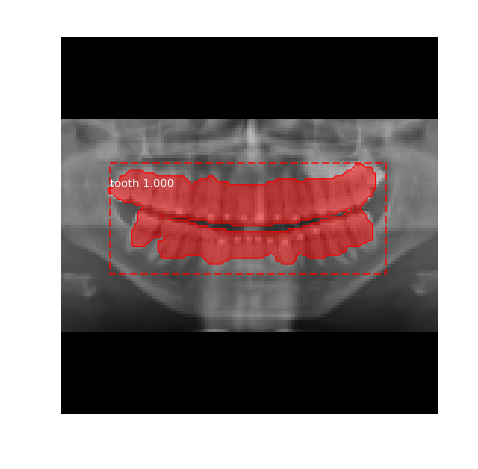

In [29]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            teeth_dataset_eval.class_names, r['scores'], ax=get_ax())

## Evaluation

In [29]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(teeth_dataset_eval.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(teeth_dataset_eval, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0


In [47]:
from os.path import isfile, join
DATASET_TEST = "./dataset_gil/test"
for dir_path in os.listdir(DATASET_TEST):
    path_current = join(join(DATASET_TEST, dir_path), "cortadas")
    path_files = [join(path_current, f) for f in listdir(path_current) if isfile(join(path_current, f))]
    for file in path_files:
        img = skimage.io.imread(file)
        results = model.detect([img], verbose=0)
        r = results[0]
        
        print(file)
        #Save mask
        head, tail = os.path.split(file)
        tail = tail.split(".")[0] + ".bmp"
        save_path = join(join(head, "mask"), tail)
        skimage.io.imsave(save_path, r['masks'][:,:,0]*255)

./dataset_gil/test/003/cortadas/41.jpg
./dataset_gil/test/003/cortadas/45.jpg
./dataset_gil/test/003/cortadas/42.jpg
./dataset_gil/test/003/cortadas/43.jpg
./dataset_gil/test/003/cortadas/38.jpg
./dataset_gil/test/003/cortadas/39.jpg
./dataset_gil/test/003/cortadas/44.jpg
./dataset_gil/test/003/cortadas/40.jpg
./dataset_gil/test/009/cortadas/41.jpg
./dataset_gil/test/009/cortadas/45.jpg
./dataset_gil/test/009/cortadas/42.jpg
./dataset_gil/test/009/cortadas/43.jpg
./dataset_gil/test/009/cortadas/38.jpg
./dataset_gil/test/009/cortadas/39.jpg
./dataset_gil/test/009/cortadas/44.jpg
./dataset_gil/test/009/cortadas/40.jpg
./dataset_gil/test/005/cortadas/102.jpg
./dataset_gil/test/005/cortadas/97.jpg
./dataset_gil/test/005/cortadas/110.jpg
./dataset_gil/test/005/cortadas/119.jpg
./dataset_gil/test/005/cortadas/100.jpg
./dataset_gil/test/005/cortadas/107.jpg
./dataset_gil/test/005/cortadas/111.jpg
./dataset_gil/test/005/cortadas/101.jpg
./dataset_gil/test/005/cortadas/118.jpg
./dataset_gil/tes

./dataset_gil/test/008/cortadas/431.jpg
./dataset_gil/test/008/cortadas/400.jpg
./dataset_gil/test/008/cortadas/389.jpg
./dataset_gil/test/008/cortadas/439.jpg
./dataset_gil/test/008/cortadas/430.jpg
./dataset_gil/test/008/cortadas/398.jpg
./dataset_gil/test/008/cortadas/397.jpg
./dataset_gil/test/008/cortadas/425.jpg
./dataset_gil/test/008/cortadas/416.jpg
./dataset_gil/test/008/cortadas/434.jpg
./dataset_gil/test/008/cortadas/376.jpg
./dataset_gil/test/008/cortadas/407.jpg
./dataset_gil/test/008/cortadas/413.jpg
./dataset_gil/test/008/cortadas/442.jpg
./dataset_gil/test/008/cortadas/449.jpg
./dataset_gil/test/008/cortadas/447.jpg
./dataset_gil/test/008/cortadas/448.jpg
./dataset_gil/test/008/cortadas/443.jpg
./dataset_gil/test/008/cortadas/401.jpg
./dataset_gil/test/008/cortadas/396.jpg
./dataset_gil/test/008/cortadas/423.jpg
./dataset_gil/test/008/cortadas/392.jpg
./dataset_gil/test/008/cortadas/390.jpg
./dataset_gil/test/008/cortadas/426.jpg
./dataset_gil/test/008/cortadas/399.jpg
